In [360]:
import pandas as pd
import numpy as np
import os
from scipy import optimize
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Data curation

In [2]:
#  define the exponential function
def func(time,a,kobs):
    return a*(1-np.exp(-kobs*time))

In [3]:
file_path = './CCDi_data/Ratios/50_2/Di_50uM_Di_4GF_2uM_25degC_rep1.txt'


In [180]:
def file_to_data(file_path,trim=(0,-1)):
    
    # Define the regular expression pattern
    pattern = r'Di_(\d+)uM_Di_4GF_(\d+)uM_(\d+)degC_rep(\d+)'

    # Find all numbers in the string using regex
    match = re.findall(pattern, file_path)

    match = match[0]

    # Check if a match is found
    if match:
        # Extract numbers from groups
        conc_Di = int(match[0])
        conc_DiF = int(match[1])
        temp = int(match[2])
        rep = int(match[3])

        # Print the numbers
        print(f"The concentration of CC-Di was: {conc_Di}")
        print(f"The concentration of labelled CC-Di was: {conc_DiF}")
        print(f"The temperature was: {temp}°C")
        print(f"The is replicate number: {rep}")
        print(f"Reading file at: {file_path}")
        
        # Read raw data
        df = pd.read_csv(file_path,
                    delimiter='\t',
                    header=None,
                    skiprows=18)
        #  Add column headers
        df.columns=['t','F']
        df['temp']=temp
        df['concDi']=conc_Di
        df['concDiF']=conc_DiF
        df['rep']=rep
        df['filepath']=file_path

    else:
        print("No match found.")
        df = None
        
    if df.empty:
        print("No data")
    else:
        xdata=df['t']
        ydata=df['F']
        plt.figure(0,(6,5))
        plt.title(f"{conc_Di}uM CC-Di with {conc_DiF}uM CC-DiF,\nat {temp}°C, rep {rep},\nin PBS at pH 7.4",fontsize=8)
        plt.plot(xdata,ydata)
        plt.axvline(xdata[trim[0]],c='orange')
        plt.axvline(xdata[len(xdata)+trim[1]],c='orange')
        plt.legend(labels=['Data'])
        
        figpath= file_path.replace('.txt','_trimmed_data.png')
        print(f"Saving plot to: {figpath}")

        plt.savefig(figpath)
    
        plt.show()
        
        
        
        df=df.iloc[trim[0]:trim[1],:]
        #normalise fluorescence
        df.loc[:, 'Fnrm'] = (df['F'] - df['F'].min()) / (df['F'].max() - df['F'].min())
        #normalise time such that the first time point is 0 seconds
        df.loc[:, 't0'] = df['t'] - df['t'].min()

        xdata=df['t0']
        ydata=df['Fnrm']

        popt, pcov = curve_fit(func, xdata, ydata,p0=[1,1])

        t = np.arange(0.0,max(xdata),0.001)
        new_value = func(t, popt[0],popt[1])
        val = func(xdata, popt[0],popt[1])

        rate = popt[1]
        half_life=(np.log(2)/popt[1])
        r2_fit = r2_score(ydata, val)
        
        plt.clf()

        plt.figure(0,(6,5))
        plt.title(f"{conc_Di}uM CC-Di with {conc_DiF}uM CC-DiF,\nat {temp}°C, rep {rep},\nin PBS at pH 7.4",fontsize=8)
        plt.plot(xdata,ydata)
        plt.plot(t,new_value)
        plt.legend(labels=['Data','Fit'])
        fit_data_string = (fr"rate = {np.round(rate, 6)} $s^{{-1}}$" + "\n" +
                   fr"half life = {np.round(half_life, 1)} $s^{{-1}}$" + "\n" +
                   fr"$R^2$ fit = {np.round(r2_fit, 3)}")
        plt.annotate(fit_data_string, xy=(0.7,0.05), xycoords='axes fraction')

        plt.tight_layout()
        
        data = {'temp':temp,
                'concDi':conc_Di,
                'concDiF':conc_DiF,
                'rep':rep,
                'filepath':file_path,
                'rate':rate,
                'halflife':half_life,
                'r2':r2_fit,
                'rmv from start':trim[0],
                'rmv from end':trim[1],
        }
        
        
        figpath= file_path.replace('txt','png')
        print(f"Saving plot to: {figpath}")
        data['figpath']=figpath
        plt.savefig(figpath)
    
        plt.show()
        
        return df, data
            
    
    

In [181]:

def find_txt_files(folder):
    txt_files = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".txt"):
                txt_files.append(os.path.join(root, file))
    return txt_files

folder_path = "./CCDi_data/Ratios_const_labelled/"
txt_files = find_txt_files(folder_path)

In [182]:
txt_files

['./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios/0_2/CCDi_0uM_CCDi4GF_2uM_PBS_25degC_rep1.txt',
 './CCDi_data/Ratios/20_2/Di_20uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios/20_2/Di_20uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios/20_2/Di_20uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios/10_2/Di_10uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios/10_2/Di_10uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios/10_2/Di_10uM_Di_4

The concentration of CC-Di was: 200
The concentration of labelled CC-Di was: 2
The temperature was: 25°C
The is replicate number: 2
Reading file at: ./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep2.txt
Saving plot to: ./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep2_trimmed_data.png


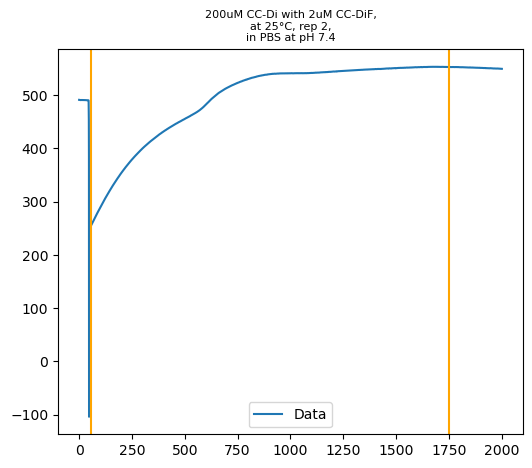

/Users/phr361/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Saving plot to: ./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep2.png


<Figure size 640x480 with 0 Axes>

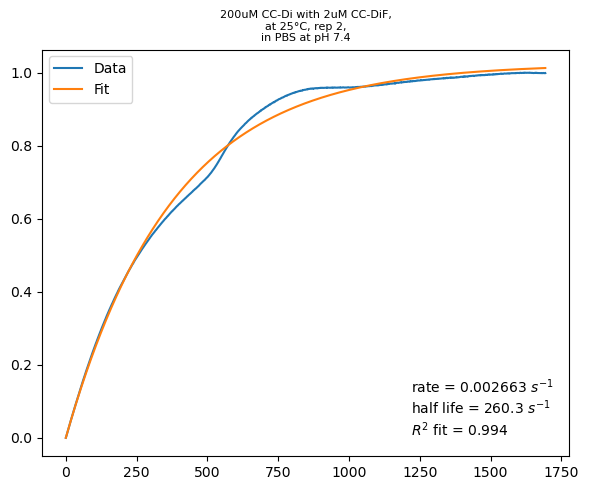

In [183]:
df, data= file_to_data(txt_files[0],
            trim=(113,-500))

In [184]:
master_df = df.copy()

master_dict = [data.copy()]

In [185]:
txt_files

['./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios/0_2/CCDi_0uM_CCDi4GF_2uM_PBS_25degC_rep1.txt',
 './CCDi_data/Ratios/20_2/Di_20uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios/20_2/Di_20uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios/20_2/Di_20uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios/10_2/Di_10uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios/10_2/Di_10uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios/10_2/Di_10uM_Di_4

In [353]:
df, data= file_to_data(txt_files[28],
            trim=(90,-1))

IndexError: list index out of range

In [350]:
master_df = pd.concat([master_df,df],ignore_index=True)

master_dict.append(data)

In [351]:
master_df

,t,F,temp,concDi,concDiF,rep,filepath,Fnrm,t0
0,56.5,255.193,25,200,2,2,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.000000,0.0
1,57.0,255.479,25,200,2,2,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.000959,0.5
2,57.5,255.845,25,200,2,2,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.002186,1.0
3,58.0,256.251,25,200,2,2,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.003547,1.5
4,58.5,256.640,25,200,2,2,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.004851,2.0
...,...,...,...,...,...,...,...,...,...
109918,4995.0,297.223,25,2,2,1,./CCDi_data/Ratios/2_2/Di_2uM_Di_4GF_2uM_25deg...,0.910141,4905.0
109919,4996.0,298.194,25,2,2,1,./CCDi_data/Ratios/2_2/Di_2uM_Di_4GF_2uM_25deg...,0.918058,4906.0
109920,4997.0,296.184,25,2,2,1,./CCDi_data/Ratios/2_2/Di_2uM_Di_4GF_2uM_25deg...,0.901670,4907.0
109921,4998.0,300.241,25,2,2,1,./CCDi_data/Ratios/2_2/Di_2uM_Di_4GF_2uM_25deg...,0.934748,4908.0


In [508]:
master_df.to_excel('df_const_CCDiF.xlsx')

In [355]:
master_dict

[{'temp': 25,
  'concDi': 200,
  'concDiF': 2,
  'rep': 2,
  'filepath': './CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep2.txt',
  'rate': 0.0026627093357282257,
  'halflife': 260.3165021654067,
  'r2': 0.9936433429891409,
  'rmv from start': 113,
  'rmv from end': -500,
  'figpath': './CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep2.png'},
 {'temp': 25,
  'concDi': 200,
  'concDiF': 2,
  'rep': 3,
  'filepath': './CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep3.txt',
  'rate': 0.0027450692011117403,
  'halflife': 252.50626843185734,
  'r2': 0.999489238119231,
  'rmv from start': 56,
  'rmv from end': -1,
  'figpath': './CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep3.png'},
 {'temp': 25,
  'concDi': 200,
  'concDiF': 2,
  'rep': 1,
  'filepath': './CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_25degC_rep1.txt',
  'rate': 0.0024418241344866245,
  'halflife': 283.8644973527851,
  'r2': 0.9931724614142623,
  'rmv from start': 85,
  'rmv from end': -4500,
  'figp

In [357]:
df_rates=pd.DataFrame(master_dict)

In [358]:
df_rates

,temp,concDi,concDiF,rep,filepath,rate,halflife,r2,rmv from start,rmv from end,figpath
0,25,200,2,2,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.002663,260.316502,0.993643,113,-500,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...
1,25,200,2,3,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.002745,252.506268,0.999489,56,-1,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...
2,25,200,2,1,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.002442,283.864497,0.993172,85,-4500,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...
3,25,100,2,1,./CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_2...,0.001586,437.127623,0.996571,155,-1,./CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_2...
4,25,100,2,3,./CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_2...,0.001917,361.592422,0.999678,154,-1,./CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_2...
5,25,100,2,2,./CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_2...,0.001968,352.227880,0.989457,220,-1,./CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_2...
6,25,30,2,2,./CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25d...,0.001050,660.016444,0.996162,80,-1,./CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25d...
7,25,30,2,3,./CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25d...,0.001101,629.666376,0.996186,110,-1,./CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25d...
8,25,30,2,1,./CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25d...,0.001120,619.135954,0.997861,90,-1,./CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25d...
9,25,20,2,1,./CCDi_data/Ratios/20_2/Di_20uM_Di_4GF_2uM_25d...,0.001044,663.797951,0.998184,90,-1,./CCDi_data/Ratios/20_2/Di_20uM_Di_4GF_2uM_25d...


In [379]:
df_rates = df_rates.drop(index=21)

In [380]:
df_rates['concDiM']=df_rates['concDi']/1000000

In [381]:
df_rates.columns

Index(['temp', 'concDi', 'concDiF', 'rep', 'filepath', 'rate', 'halflife',
       'r2', 'rmv from start', 'rmv from end', 'figpath', 'concDiM'],
      dtype='object')

In [507]:
df_rates.to_excel('df_rates_constant_CCDiF.xlsx')

In [403]:
df_rates

,temp,concDi,concDiF,rep,filepath,rate,halflife,r2,rmv from start,rmv from end,figpath,concDiM
0,25,200,2,2,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.002663,260.316502,0.993643,113,-500,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.000200
1,25,200,2,3,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.002745,252.506268,0.999489,56,-1,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.000200
2,25,200,2,1,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.002442,283.864497,0.993172,85,-4500,./CCDi_data/Ratios/200_2/Di_200uM_Di_4GF_2uM_2...,0.000200
3,25,100,2,1,./CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_2...,0.001586,437.127623,0.996571,155,-1,./CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_2...,0.000100
4,25,100,2,3,./CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_2...,0.001917,361.592422,0.999678,154,-1,./CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_2...,0.000100
5,25,100,2,2,./CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_2...,0.001968,352.227880,0.989457,220,-1,./CCDi_data/Ratios/100_2/Di_100uM_Di_4GF_2uM_2...,0.000100
6,25,30,2,2,./CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25d...,0.001050,660.016444,0.996162,80,-1,./CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25d...,0.000030
7,25,30,2,3,./CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25d...,0.001101,629.666376,0.996186,110,-1,./CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25d...,0.000030
8,25,30,2,1,./CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25d...,0.001120,619.135954,0.997861,90,-1,./CCDi_data/Ratios/30_2/Di_30uM_Di_4GF_2uM_25d...,0.000030
9,25,20,2,1,./CCDi_data/Ratios/20_2/Di_20uM_Di_4GF_2uM_25d...,0.001044,663.797951,0.998184,90,-1,./CCDi_data/Ratios/20_2/Di_20uM_Di_4GF_2uM_25d...,0.000020


In [401]:
folder_path = "./CCDi_data/Ratios_const_unlabelled/"
txt_files = find_txt_files(folder_path)

The concentration of CC-Di was: 200
The concentration of labelled CC-Di was: 1
The temperature was: 25°C
The is replicate number: 2
Reading file at: ./CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep2.txt
Saving plot to: ./CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep2_trimmed_data.png


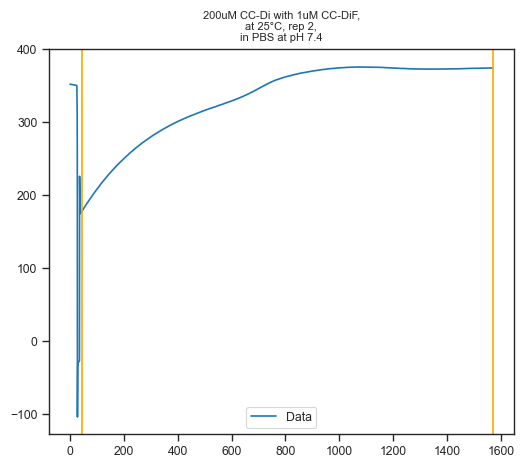

/Users/phr361/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Saving plot to: ./CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep2.png


<Figure size 640x480 with 0 Axes>

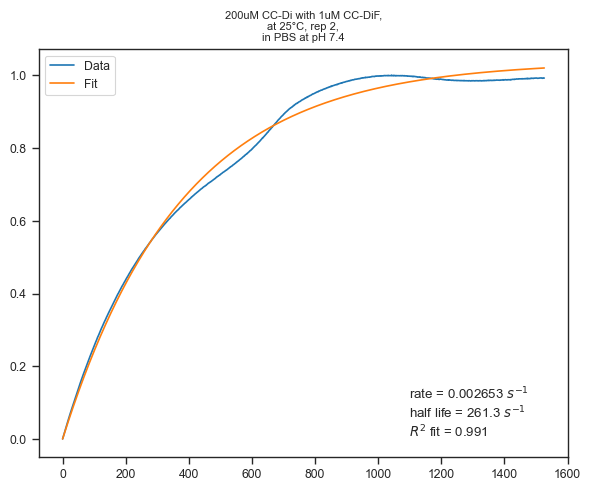

In [419]:
df, data= file_to_data(txt_files[0],
            trim=(88,-1))

In [420]:
master_df_constant_CCDi = df.copy()

master_dict_constant_CCDi = [data.copy()]

In [421]:
txt_files

['./CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_1uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_5uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_5uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_5uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_2uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_2uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_2uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_10uM_25degC_rep1.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_10uM_25degC_rep3.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_10uM_25degC_rep2.txt',
 './CCDi_data/Ratios_const_unlabelled/Di_200uM_Di_4GF_20uM_25degC_rep2.txt',
 './CCDi

In [485]:
df, data= file_to_data(txt_files[15],
            trim=(105,-1))

IndexError: list index out of range

In [484]:
master_df_constant_CCDi = pd.concat([master_df_constant_CCDi,df],ignore_index=True)

master_dict_constant_CCDi.append(data)

In [505]:
master_df_constant_CCDi.to_excel('master_df_constant_CCDi.xlsx')

In [486]:
df_rates_constant_CCDi=pd.DataFrame(master_dict_constant_CCDi)

In [506]:
df_rates_constant_CCDi.to_excel('df_rates_constant_CCDi.xlsx')

In [493]:
df_rates_constant_CCDi

,temp,concDi,concDiF,rep,filepath,rate,halflife,r2,rmv from start,rmv from end,figpath
0,25,200,1,2,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002653,261.255894,0.991459,88,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
1,25,200,1,3,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002838,244.207218,0.999934,100,-100,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
2,25,200,1,1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002445,283.533971,0.999514,122,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
3,25,200,5,1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002523,274.712704,0.997231,92,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
4,25,200,5,2,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002766,250.623810,0.999655,88,-700,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
5,25,200,5,3,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002768,250.457331,0.999839,70,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
6,25,200,2,2,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002663,260.316502,0.993643,113,-500,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
7,25,200,2,3,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002745,252.506268,0.999489,56,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
8,25,200,2,1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002442,283.864497,0.993172,85,-4500,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...
9,25,200,10,1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...,0.002507,276.488302,0.996912,100,-1,./CCDi_data/Ratios_const_unlabelled/Di_200uM_D...


In [514]:
folder_path = "./CCDi_data/Arhenius_files/"
txt_files = find_txt_files(folder_path)

In [515]:
txt_files

['./CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep1.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep2.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep3.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_40degC_rep3.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_40degC_rep2.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_40degC_rep1.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_37degC_rep1.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_37degC_rep2.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_37degC_rep3.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_28degC_rep2.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_28degC_rep3.txt',
 './CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_28degC_rep1.txt']

The concentration of CC-Di was: 20
The concentration of labelled CC-Di was: 2
The temperature was: 32°C
The is replicate number: 1
Reading file at: ./CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep1.txt
Saving plot to: ./CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep1_trimmed_data.png


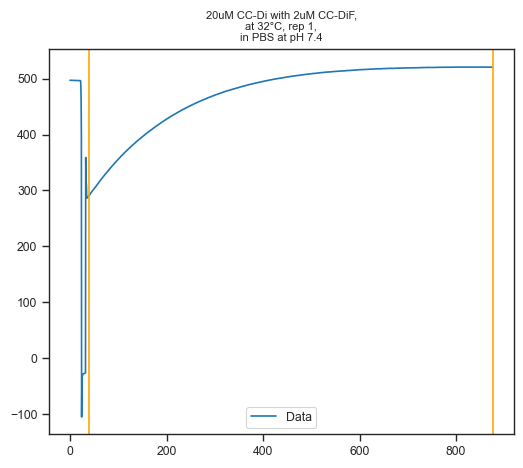

/Users/phr361/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Saving plot to: ./CCDi_data/Arhenius_files/Di_20uM_Di_4GF_2uM_32degC_rep1.png


<Figure size 640x480 with 0 Axes>

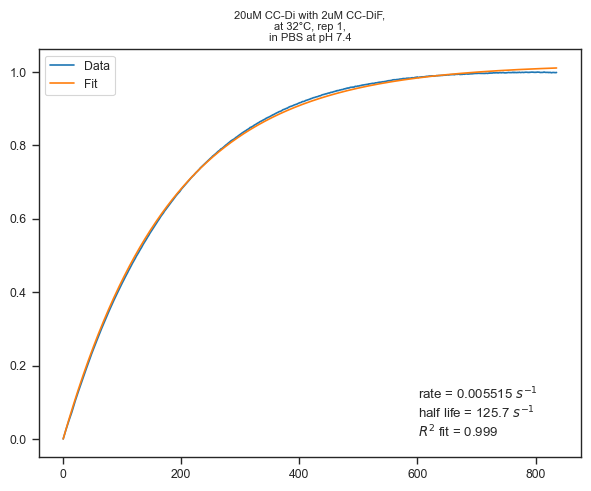

In [516]:
df, data= file_to_data(txt_files[0],
            trim=(80,-1))

In [517]:
master_df_varTemp = df.copy()

master_dict_varTemp = [data.copy()]

In [576]:
df, data= file_to_data(txt_files[12],
            trim=(100,-1))

IndexError: list index out of range

In [575]:
master_df_varTemp = pd.concat([master_df_varTemp,df],ignore_index=True)

master_dict_varTemp.append(data)

In [599]:
df_rates_varTemp=pd.DataFrame(master_dict_varTemp)

In [601]:
master_df_varTemp = pd.concat([master_df_varTemp,
                               master_df[master_df['concDi']==20]],
                              ignore_index=True)
df_rates_varTemp = pd.concat([df_rates_varTemp,
                               df_rates[df_rates['concDi']==20]],
                              ignore_index=True)

In [602]:
master_df_varTemp.to_excel('master_df_varTemp.xlsx')
df_rates_varTemp.to_excel('df_rates_varTemp.xlsx')